In [1]:
# filter some warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.colors as mcolors

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cmocean

from myfunctions import openpickle, detect_polynya 
from IcePlot import modify_map

In [3]:
name = 'GFDL-CM4'
data_siconc = openpickle(name, '../../SO_data/data_siconc_w_area/')
data_sithick = openpickle(name, '../../SO_data/data_thick/')
data_mld = openpickle(name, '../../SO_data/data_mld/')
# data_polynya = openpickle(name, '../../SO_data/data_polynya/')

In [4]:
def adjust_subplot():
    plt.subplots_adjust(left=0.015,
                        bottom=0.02, 
                        right=0.925,
                        top=0.98,
                        wspace=0.15,
                        hspace=0.08)

In [5]:
def detect_polynya_sithick(da_ice, da_thick, da_area, ice_threshold, area_threshold=(100, 1000), flood_points = [(0,0)], buffering = 15):
    from scipy import ndimage
    from skimage.segmentation import flood_fill
    # Copy the input data arrays to avoid modifying the original data
    daice = da_ice.copy()
    dathick = da_thick.copy()
    daarea = da_area.copy()

    # Fill NaN values in the area data array with the mean value
    daarea = daarea.fillna(daarea.mean().values.item())
    
    # Generate a binary structure for labeling connected components
    s = ndimage.generate_binary_structure(2,2)
    
    # Create an empty masked data array with the same dimensions as the input data
    da_masked = xr.DataArray(np.nan*np.empty_like(dathick), dims = dathick.dims, coords = dathick.coords)
    
    # Loop through each time step in the data array
    for year in daice.time:
        # Copy the sea ice concentration data for the current time step and fill NaN values with 0
        ice0_flood = daice.sel(time = year).copy()
        ice0_flood = ice0_flood.fillna(0).values
        
        # Apply flood fill to remove coastal areas based on the provided flood points
        for flood_point in flood_points:
            ice0_flood = flood_fill(ice0_flood, flood_point, 0, tolerance=buffering)
        
        # Apply flood fill to remove areas outside the sea ice extent
        ice0_flood = flood_fill(ice0_flood, (ice0_flood.shape[0]-1, ice0_flood.shape[1]-1), 0, tolerance=buffering)

        icethick0 = dathick.sel(time = year).copy()
        icethick0 = icethick0.fillna(0).values
        icethick0 = np.where(ice0_flood>0, icethick0, 0)

        # Identify areas with sea ice concentration below the threshold
        icenew = icethick0 <= ice_threshold
        
        # Label connected components in the binary image
        labeled_image, num_features = ndimage.label(icenew, structure = s)
        
        # If there are less than 2 features, skip to the next time step
        if num_features < 2:
            continue
        
        # Initialize a mask to store the detected polynyas
        mask = np.zeros_like(labeled_image)
        
        # Loop through each labeled feature
        for i in range(1, num_features+1):
            # Calculate the area of the current feature
            area = daarea.where(labeled_image == i).sum()/1e9  # m2 -> 10^3 km2
            
            # If the area is within the specified thresholds, mark it as a polynya
            if (area > area_threshold[0]) and (area < area_threshold[1]):
                mask[labeled_image == i] = 1
        
        # Mask the sea ice concentration data for the current time step
        ice_value = dathick.sel(time=year).values
        ice_value[mask == 0] = np.nan
        da_masked.loc[year] = ice_value
    
    # Return the masked data array
    return da_masked

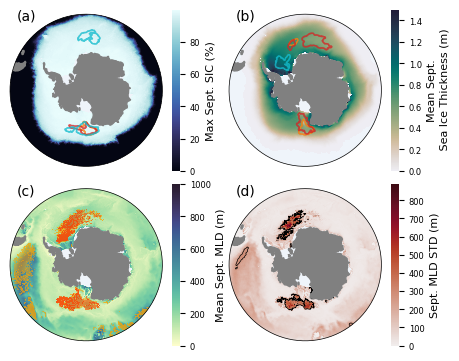

In [6]:
fig = plt.figure(figsize=(4.5, 3.5))

ax1 = fig.add_subplot(2, 2, 3, projection=ccrs.SouthPolarStereo())
adjust_subplot()

mldavg = data_mld.mld.mean('time')
im1 = ax1.pcolormesh(data_mld.newlon, data_mld.newlat, mldavg, 
                  transform=ccrs.PlateCarree(), cmap=cmocean.cm.deep)
im1.set_clim(0, 1000)
cbar1 = plt.colorbar(im1, ax=ax1, label='meters', pad=0.05)
cbar1.set_label('Mean Sept. MLD (m)', size=8)
cbar1.ax.tick_params(labelsize=6)
cbar1.outline.set_visible(False)

mld1000 = xr.where(data_mld.mld.where(data_mld.mld>=1000).mean('time')>0, 1, np.nan)
ax1.pcolormesh(data_mld.newlon, data_mld.newlat, mld1000,
               transform=ccrs.PlateCarree(), cmap=mcolors.ListedColormap(['orange']), alpha=0.5)

mld2000 = xr.where(data_mld.mld.where(data_mld.mld>=2000).mean('time')>0, 1, np.nan)
ax1.pcolormesh(data_mld.newlon, data_mld.newlat, mld2000,
               transform=ccrs.PlateCarree(), cmap=mcolors.ListedColormap(['red']), alpha=0.3)
ax1.text(-45, -40, '(c)', transform=ccrs.PlateCarree())
modify_map(ax1)


ax2 = fig.add_subplot(2, 2, 4, projection=ccrs.SouthPolarStereo())
adjust_subplot()
mldstd = data_mld.mld.std("time")
im2 = ax2.pcolormesh(data_mld.newlon, data_mld.newlat, mldstd, 
                     transform=ccrs.PlateCarree(), cmap=cmocean.cm.amp)
cbar2 = plt.colorbar(im2, ax=ax2, label='meters', pad=0.05)
cbar2.set_label('Sept. MLD STD (m)', size=8)
cbar2.ax.tick_params(labelsize=6)
cbar2.outline.set_visible(False)
mldzscore = (mldstd - mldstd.mean())/mldstd.std()
ax2.contour(data_mld.newlon, data_mld.newlat, mldzscore, 
            transform=ccrs.PlateCarree(),
            levels=[2], colors='k', linewidths=0.5)
ax2.text(-45, -40, '(d)', transform=ccrs.PlateCarree())
modify_map(ax2)


ax3 = fig.add_subplot(2, 2, 1, projection=ccrs.SouthPolarStereo())
adjust_subplot()
siconcmax = data_siconc.siconc.max('time')
im3 = ax3.pcolormesh(data_siconc.newlon, data_siconc.newlat, siconcmax,
                     transform=ccrs.PlateCarree(), cmap=cmocean.cm.ice)

cbar3 = plt.colorbar(im3, ax=ax3, label='fraction', pad=0.05)
cbar3.set_label('Max Sept. SIC (%)', size=8)
cbar3.ax.tick_params(labelsize=6)
cbar3.outline.set_visible(False)


ax3.contour(data_siconc.newlon, data_siconc.newlat, 
            xr.where(detect_polynya(data_siconc.siconc, data_siconc.areacello, 15).count('time')>0, 1.0, 0),
            transform=ccrs.PlateCarree(), colors='C1', linewidths=1, alpha = 0.2)

ax3.contour(data_siconc.newlon, data_siconc.newlat, 
            xr.where(detect_polynya(data_siconc.siconc, data_siconc.areacello, 45).count('time')>0, 1.0, 0),
            transform=ccrs.PlateCarree(), colors='C3', linewidths=1, alpha = 0.2)

ax3.contour(data_siconc.newlon, data_siconc.newlat, 
            xr.where(detect_polynya(data_siconc.siconc, data_siconc.areacello, 75).count('time')>0, 1.0, 0),
            transform=ccrs.PlateCarree(), colors='C9', linewidths=1, alpha = 0.2)

ax3.text(-45, -40, '(a)', transform=ccrs.PlateCarree())
modify_map(ax3)


ax4 = fig.add_subplot(2, 2, 2, projection=ccrs.SouthPolarStereo())
adjust_subplot()
sithickavg = data_sithick.sithick.mean('time')
im4 = ax4.pcolormesh(data_sithick.newlon, data_sithick.newlat, sithickavg.where(sithickavg>0),
                     transform=ccrs.PlateCarree(), cmap=cmocean.cm.rain)
im4.set_clim(0, 1.5)
ax4.contour(data_sithick.newlon, data_sithick.newlat, 
            xr.where(detect_polynya_sithick(data_siconc.siconc, data_sithick.sithick, data_sithick.areacello, 0.2).count('time')>0, 1.0, 0),
            transform=ccrs.PlateCarree(), colors='C1', linewidths=1, alpha = 0.2)
ax4.contour(data_sithick.newlon, data_sithick.newlat, 
            xr.where(detect_polynya_sithick(data_siconc.siconc, data_sithick.sithick, data_sithick.areacello, 0.5).count('time')>0, 1.0, 0),
            transform=ccrs.PlateCarree(), colors='C3', linewidths=1, alpha = 0.2)
ax4.contour(data_sithick.newlon, data_sithick.newlat, 
            xr.where(detect_polynya_sithick(data_siconc.siconc, data_sithick.sithick, data_sithick.areacello, 0.8).count('time')>0, 1.0, 0),
            transform=ccrs.PlateCarree(), colors='C9', linewidths=1, alpha = 0.2)

cbar4 = plt.colorbar(im4, ax=ax4, label='meters', pad=0.05)
cbar4.set_label('Mean Sept.\n Sea Ice Thickness (m)', size=8)
cbar4.ax.tick_params(labelsize=6)
cbar4.outline.set_visible(False)
ax4.text(-45, -40, '(b)', transform=ccrs.PlateCarree())
modify_map(ax4)

fig.savefig('Methods.png', dpi = 300)
# fig.savefig('Methods.eps', format='eps')  # too big (should be less than 5MB
# fig.savefig('Methods.pdf', format='pdf')  # too big (should be less than 5MB

In [12]:
test = detect_polynya_sithick(data_siconc.siconc, data_sithick.sithick, data_sithick.areacello, 0.1)

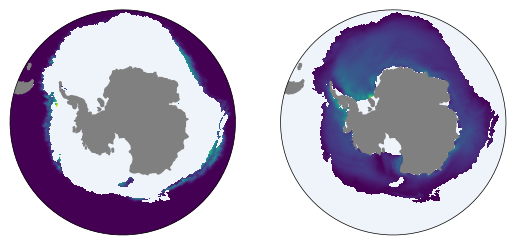

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
ax.pcolormesh(
    data_sithick.newlon,
    data_sithick.newlat,
    data_sithick.sithick.isel(time = 84).where(data_sithick.sithick.isel(time = 188)<0.1), 
    transform=ccrs.PlateCarree()
)
modify_map(ax)
ax = fig.add_subplot(1, 2, 2, projection=ccrs.SouthPolarStereo())
ax.pcolormesh(
    data_sithick.newlon,
    data_sithick.newlat,
    data_sithick.sithick.isel(time = 84).where(data_sithick.sithick.isel(time = 188)>0.1), 
    transform=ccrs.PlateCarree()
)
modify_map(ax)

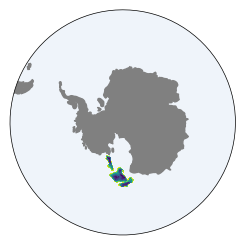

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
ax.pcolormesh(
    data_sithick.newlon,
    data_sithick.newlat,
    test.mean('time'),
    transform=ccrs.PlateCarree()
)
modify_map(ax)